## Обучение модели проходило на Google Calabotory

In [1]:
!nvidia-smi

Tue Sep 22 21:26:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qq transformers

     |████████████████████████████████| 1.0MB 5.3MB/s 
     |████████████████████████████████| 3.0MB 36.0MB/s 
     |████████████████████████████████| 890kB 57.1MB/s 
     |████████████████████████████████| 1.1MB 53.3MB/s 


In [3]:
import transformers
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
df = pd.read_csv('Data/train.csv')
df.head(10)

,id,text,label
0,0,Как отключить тариф?,FAQ - тарифы и услуги
1,1,тариф,мобильная связь - тарифы
2,2,тариф,мобильная связь - тарифы
3,3,Здрасте я хотел получить золотую карту,FAQ - тарифы и услуги
4,4,Золотую карту,FAQ - тарифы и услуги
5,5,Как отключить доступ в интернет,Мобильный интернет
6,6,Как запретить все звонки вне сети оператор,FAQ - интернет
7,7,тарифы для интернета,мобильная связь - тарифы
8,8,тариф,мобильная связь - тарифы
9,9,«тариф»,мобильная связь - тарифы


In [6]:
import json
with open('Dicts/class_to_num.json') as f:
    class_to_num = json.load(f)
class_to_num

{'FAQ - интернет': 3,
 'FAQ - тарифы и услуги': 0,
 'SIM-карта и номер': 9,
 'Баланс': 5,
 'Личный кабинет': 8,
 'Мобильные услуги': 6,
 'Мобильный интернет': 2,
 'Оплата': 7,
 'Роуминг': 10,
 'Устройства': 12,
 'запрос обратной связи': 11,
 'мобильная связь - зона обслуживания': 13,
 'мобильная связь - тарифы': 1,
 'тарифы - подбор': 4}

In [7]:
df.label = df.label.replace(class_to_num)

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Для обучения нужно преобразовать наши данные в тот вид, в котором его принимает Bert

In [9]:
class RequestDataset(data.Dataset):
    
    def __init__(self, request, target, tokenizer, max_len):
        self.request = request
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.request)
    
    def __getitem__(self, item):
        request = str(self.request[item])
        
        encoding = tokenizer.encode_plus(
            request,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        
        return{
            'request_text' : request,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'targets' : torch.tensor(self.target[item], dtype=torch.long)
        }

In [10]:
MAX_LEN = 50
BATCH_SIZE = 40
EPOCHS = 20

In [11]:
df_train, df_test_tmp =  train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_test, df_val =  train_test_split(df_test_tmp, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_test.shape, df_val.shape

((29520, 3), (1640, 3), (1640, 3))

In [12]:
def creat_data_loader(df, tokenizer, max_len, batch_size):
    ds = RequestDataset(
        request=df.text.to_numpy(),
        target=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [13]:
train_data_loader = creat_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = creat_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = creat_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [14]:
data_new = next(iter(train_data_loader))
data_new.keys()

dict_keys(['request_text', 'input_ids', 'attention_mask', 'targets'])

In [15]:
bert_model = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model.config.hidden_size

768

#### Пропишем наш классификатор

In [16]:
class SentimentClassClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassClassifier, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        output = self.out(output)
        
        return self.softmax(output)
#         return output

In [17]:
model = SentimentClassClassifier(len(class_to_num))
model = model.to(device)

#### Рассчитываем веса классов

In [18]:
from sklearn.utils import class_weight
weight_of_classes = torch.tensor(class_weight.compute_class_weight('balanced', np.unique(df_train.label.values),df_train.label.values), dtype=torch.float)
weight_of_classes

tensor([ 0.6359,  0.1952,  1.7171,  2.5683,  1.2181,  0.7810,  0.5694,  1.9506,
         3.6799,  0.8834,  6.2755,  8.8969,  4.6857, 13.7815])

In [19]:
optimizer = transformers.AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss(weight=weight_of_classes).to(device)

In [20]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double()/n_examples, np.mean(losses)

In [21]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double()/n_examples, np.mean(losses)

In [22]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'Model/best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/20
----------
Train loss 2.224396086805235 accuracy 0.6395325203252032
Val   loss 2.1563521943441253 accuracy 0.7268292682926829

Epoch 2/20
----------
Train loss 2.100405129313792 accuracy 0.7478319783197832
Val   loss 2.105569371363012 accuracy 0.7225609756097561

Epoch 3/20
----------
Train loss 2.0576033831288822 accuracy 0.7706639566395664
Val   loss 2.099124507206242 accuracy 0.7432926829268293

Epoch 4/20
----------
Train loss 2.0432331360129483 accuracy 0.7820121951219512
Val   loss 2.104567312612766 accuracy 0.7585365853658537

Epoch 5/20
----------
Train loss 2.028810033630226 accuracy 0.7914972899728997
Val   loss 2.09903421634581 accuracy 0.7371951219512195

Epoch 6/20
----------
Train loss 2.0103534983425604 accuracy 0.796239837398374
Val   loss 2.0686427151284565 accuracy 0.7591463414634146

Epoch 7/20
----------
Train loss 1.9986771109304453 accuracy 0.8095867208672086
Val   loss 2.0775025007201404 accuracy 0.7621951219512195

Epoch 8/20
----------
Train loss 1.9

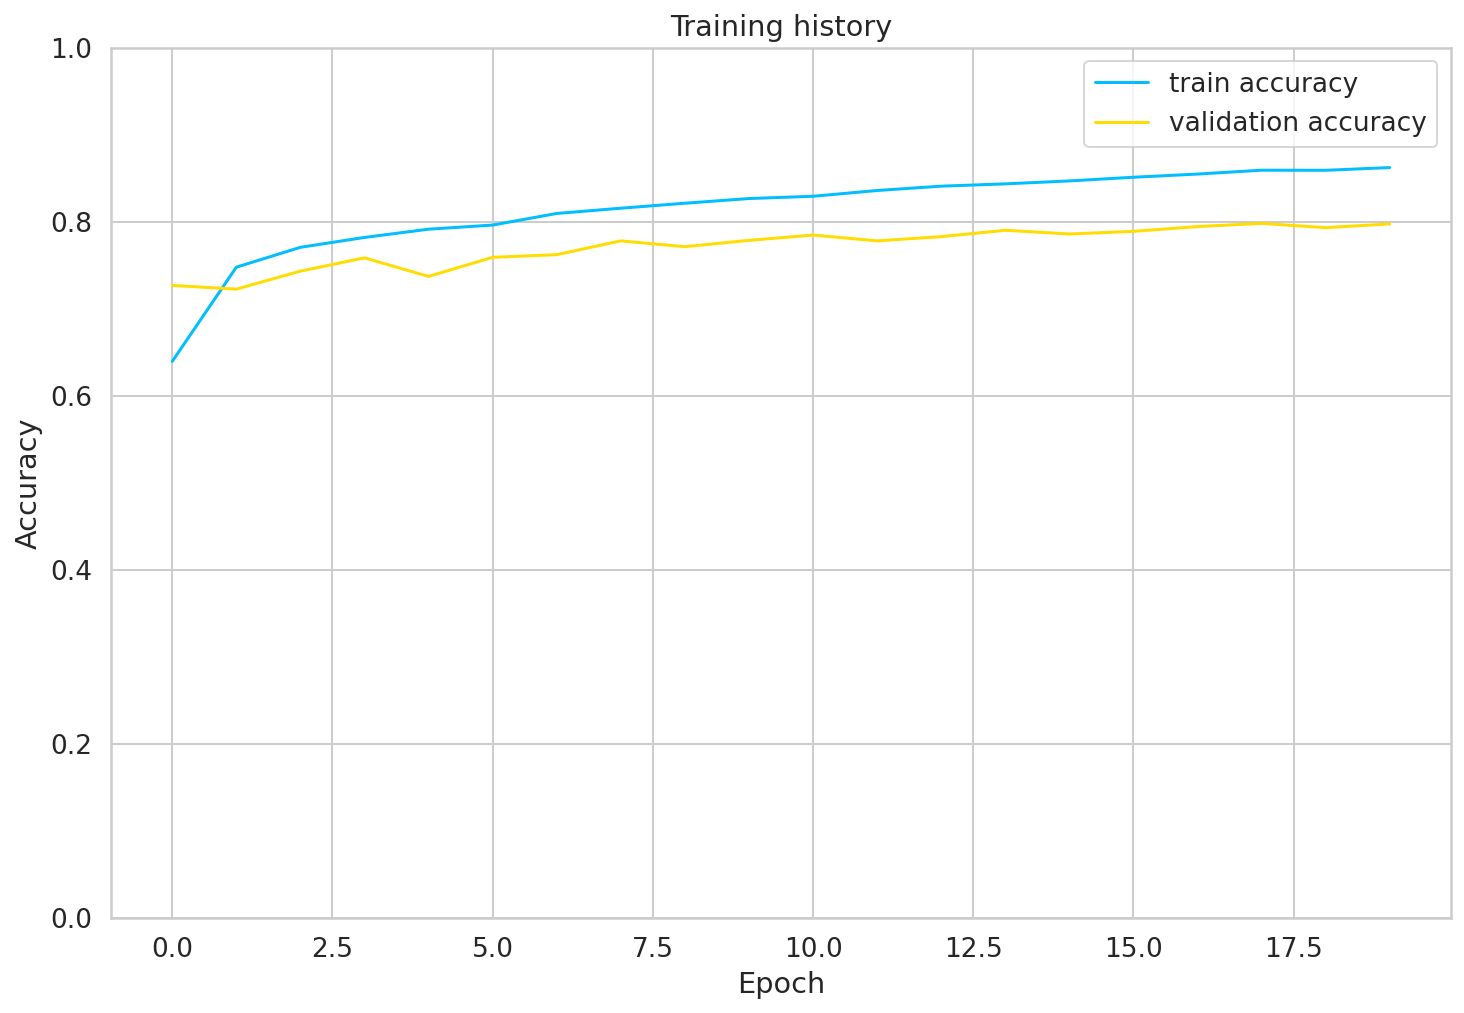

In [23]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [24]:
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn, 
    device, 
    len(df_test) 
)
test_acc

tensor(0.8226, device='cuda:0', dtype=torch.float64)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F
def get_predictions(model, data_loader):
    model = model.eval()
  
    request_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["request_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            request_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return request_texts, predictions, prediction_probs, real_values

In [26]:
y_request_texts, y_pred, y_pred_probs, y_test = get_predictions( model, test_data_loader)

In [27]:
print(classification_report(y_test, y_pred, target_names=list(class_to_num.keys())))

                                     precision    recall  f1-score   support

              FAQ - тарифы и услуги       0.80      0.67      0.73       190
           мобильная связь - тарифы       0.87      0.90      0.89       592
                 Мобильный интернет       0.81      0.77      0.79        78
                     FAQ - интернет       0.42      0.50      0.46        42
                    тарифы - подбор       0.84      0.78      0.81        74
                             Баланс       0.83      0.90      0.86       139
                   Мобильные услуги       0.80      0.70      0.75       213
                             Оплата       0.75      0.89      0.81        63
                     Личный кабинет       0.82      0.88      0.85        32
                  SIM-карта и номер       0.87      0.95      0.90       146
                            Роуминг       0.57      0.59      0.58        22
              запрос обратной связи       1.00      0.89      0.94         

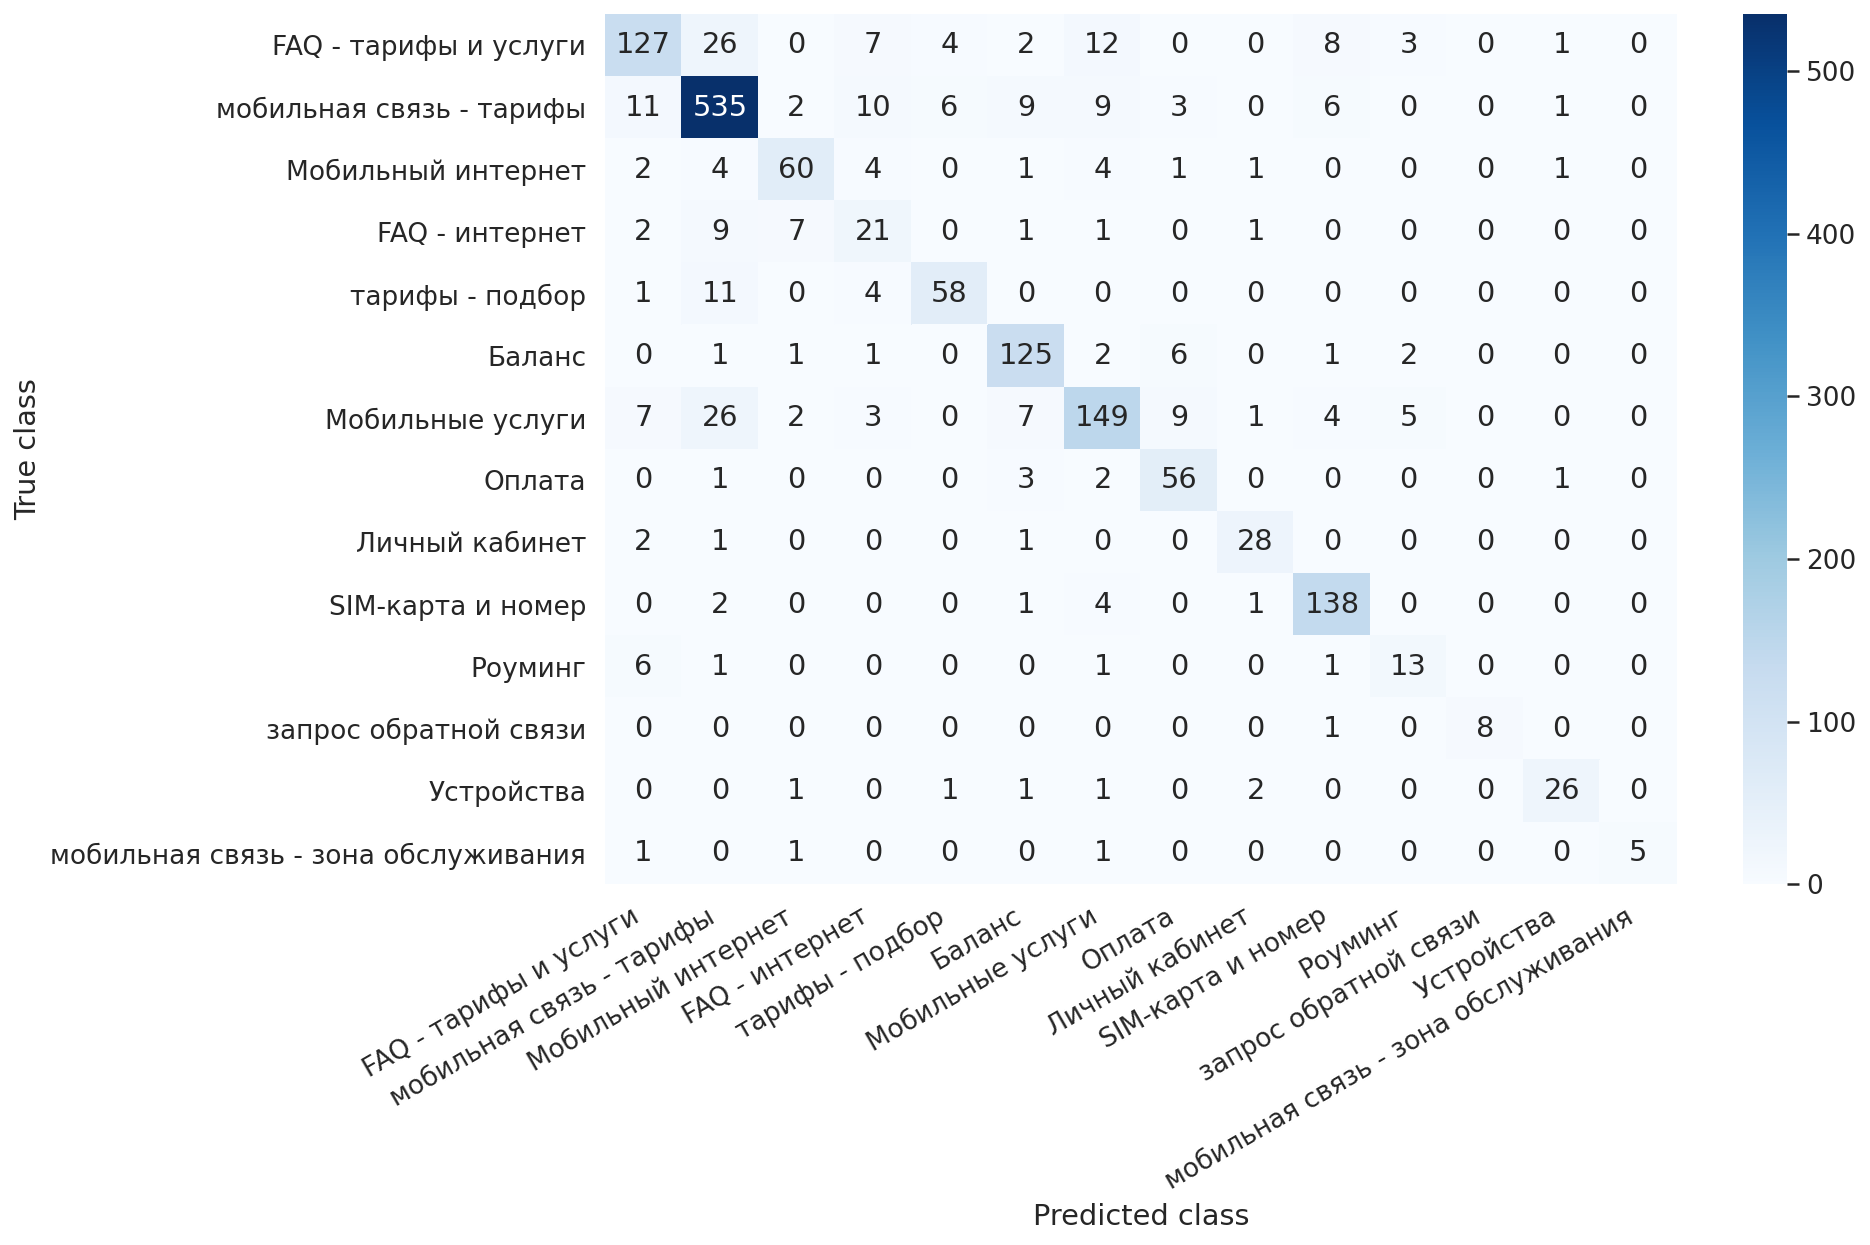

In [28]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True class')
    plt.xlabel('Predicted class');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=list(class_to_num.keys()), columns=list(class_to_num.keys()))
show_confusion_matrix(df_cm)